<a href="https://colab.research.google.com/github/spshreya/21daysofML/blob/main/CLTV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import files
uploaded = files.upload()

Saving customer_segmentation.csv to customer_segmentation.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [31]:
df = pd.read_csv('customer_segmentation.csv', encoding='cp1252')

In [8]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [32]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [9]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

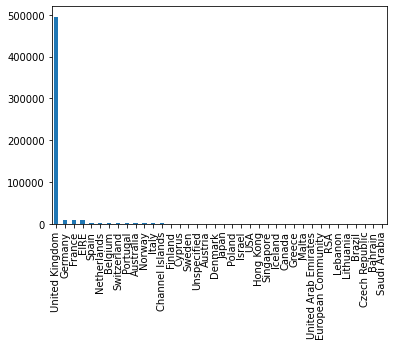

In [15]:
df['Country'].value_counts().plot.bar()

In [33]:
ukdf = df.loc[df['Country'] == 'United Kingdom']

In [18]:
ukdf.describe()   #min are negative which seems incorrect

,Quantity,UnitPrice,CustomerID
count,495478.000000,495478.000000,361878.000000
mean,8.605486,4.532422,15547.871368
std,227.588756,99.315438,1594.402590
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,14194.000000
50%,3.000000,2.100000,15514.000000
75%,10.000000,4.130000,16931.000000
max,80995.000000,38970.000000,18287.000000


In [34]:
data = ukdf[(ukdf['Quantity']>0)]
data=ukdf[['CustomerID','InvoiceDate','InvoiceNo','Quantity','UnitPrice']]
data['TotalPurchase'] = ukdf['Quantity'] * ukdf['UnitPrice']

data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice,TotalPurchase
0,17850.0,2010-12-01 08:26:00,536365,6,2.55,15.30
1,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
2,17850.0,2010-12-01 08:26:00,536365,8,2.75,22.00
3,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34
4,17850.0,2010-12-01 08:26:00,536365,6,3.39,20.34


In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 495478 entries, 0 to 541893
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   CustomerID     361878 non-null  float64       
 1   InvoiceDate    495478 non-null  datetime64[ns]
 2   InvoiceNo      495478 non-null  object        
 3   Quantity       495478 non-null  int64         
 4   UnitPrice      495478 non-null  float64       
 5   TotalPurchase  495478 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 26.5+ MB


In [23]:
#data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [36]:
data_group = data.groupby('CustomerID').agg({'InvoiceDate': lambda date: (date.max() - date.min()).days,
                                              'InvoiceNo': lambda num: len(num),
                                              'Quantity': lambda quant: quant.sum(),
                                              'TotalPurchase': lambda price: price.sum()})
# Change the name of columns
data_group.columns=['num_days', 'num_transactions', 'num_units', 'spent_money']
data_group.head()

,num_days,num_transactions,num_units,spent_money
CustomerID,,,,
12346.0,0,2,0,0.00
12747.0,366,103,1275,4196.01
12748.0,372,4642,24210,29072.10
12749.0,209,231,1422,3868.20
12820.0,323,59,722,942.34


In [37]:
uk_data_group = data_group

## CLTV

In [38]:
# Average Order Value
data_group['avg_order_value']=uk_data_group['spent_money']/uk_data_group['num_transactions']
#Purchase Frequency 
purchase_frequency=sum(uk_data_group['num_transactions'])/uk_data_group.shape[0]
# Repeat Rate
repeat_rate=uk_data_group[uk_data_group.num_transactions > 1].shape[0]/uk_data_group.shape[0]
#Churn Rate
churn_rate=1-repeat_rate

print(purchase_frequency,repeat_rate,churn_rate)

91.6146835443038 0.9807594936708861 0.019240506329113893


In [39]:
# Profit Margin
data_group['profit_margin']= data_group['spent_money']*0.25
# Customer Value
data_group['CLTV']= (data_group['avg_order_value']*purchase_frequency)/churn_rate
#Customer Lifetime Value
data_group['cust_lifetime_value']=data_group['CLTV']*data_group['profit_margin']

In [40]:
ukdf['month_yr'] = ukdf['InvoiceDate'].apply(lambda x: x.strftime('%b-%Y')) # Extract month and year from InvoiceDate.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [43]:
ukdf['TotalPurchase'] = ukdf['Quantity'] * ukdf['UnitPrice']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [44]:
ukdf.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month_yr,TotalPurchase
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Dec-2010,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Dec-2010,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Dec-2010,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Dec-2010,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Dec-2010,20.34


In [45]:
# creating a pivot table taking the columns as input, and groups the entries into a two-dimensional table in such a way that provides a multidimensional summation of the data.
sale=ukdf.pivot_table(index=['CustomerID'],columns=['month_yr'],values='TotalPurchase',aggfunc='sum',fill_value=0).reset_index()
sale['CLV']=sale.iloc[:,2:].sum(axis=1) # sum all the months sale
sale.head()


month_yr,CustomerID,Apr-2011,Aug-2011,Dec-2010,Dec-2011,Feb-2011,Jan-2011,Jul-2011,Jun-2011,Mar-2011,May-2011,Nov-2011,Oct-2011,Sep-2011,CLV
0,12346.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,12747.0,0.00,301.70,706.27,438.50,0.00,303.04,0.00,376.30,310.78,771.31,312.73,675.38,0.00,4196.01
2,12748.0,1100.37,659.42,4177.68,1070.27,389.64,418.77,1113.27,2006.26,1011.94,2224.42,9295.57,1385.84,4218.65,27971.73
3,12749.0,0.00,1750.45,0.00,763.06,0.00,0.00,0.00,0.00,0.00,782.10,572.59,0.00,0.00,3868.20
4,12820.0,0.00,0.00,0.00,210.35,0.00,170.46,0.00,0.00,0.00,0.00,0.00,343.76,217.77,942.34


## Prediction

In [48]:
X=sale[['Dec-2011','Nov-2011', 'Oct-2011','Sep-2011','Aug-2011','Jul-2011']]
y=sale[['CLV']]
#split training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
linreg = LinearRegression() # instantiate
linreg.fit(X_train, y_train) # fitting the model to the training data
y_pred = linreg.predict(X_test) # make predictions on the testing set
print(linreg.intercept_)
print(linreg.coef_)

[105.1194966]
[[1.48565943 0.82228789 1.30995314 2.01246674 1.85278568 2.81968521]]


In [50]:
print('R-Square:',r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test,y_pred))
print('MSE',mean_squared_error(y_test, y_pred))
print('RMSE:',np.sqrt(mean_squared_error(y_test, y_pred)))

R-Square: 0.9762904559200456
MAE: 491.5814679555225
MSE 2470897.15703884
RMSE: 1571.90876231378
